In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,'./')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics

2024-11-07 10:59:11.565331: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 10:59:11.598477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 10:59:12.113861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [3]:
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Add, Lambda
#import tensorflow.keras.backend as K
from keras import backend as K
#from keras.layers import Input, Lambda
#from keras.layers import Concatenate
Cp_max = 0.5926
V_mean = 6.314169410268349
V_std = 1.9826865496833004
Pres_mean = 548.729493
Pres_std = 30275.282659

Ptotal_model = tf.keras.models.load_model('./Ptotal_Cp3D.h5')
Ptotal_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 lambda_5 (Lambda)              (None, 3)            0           ['input_6[0][0]']                
                                                                                                  
 lambda_6 (Lambda)              (None, 8)            0           ['input_6[0][0]']                
                                                                                                  
 model (Functional)             (None, 1)            17153       ['lambda_5[0][0]']               
                                                                                            

2024-11-07 10:59:24.807465: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
features_dataset = pd.read_csv('./Dataset_test_features_UQ.csv')
P_dataset = pd.read_csv('./Dataset_test_P_UQ.csv')

# Remove the first column (unnamed) if it exists
features_dataset = features_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
P_dataset = P_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
print(P_dataset.columns)
print(features_dataset.columns)
print(P_dataset.shape)
print(features_dataset.shape)

Index(['P'], dtype='object')
Index(['V', 'theta', 'W', 'theta.1', 'nacelle_temperature', 'V.1',
       'Vane_angle', 'Out_temperature', 'W.1', 'Rotor_temperature',
       'Wind_angle_c'],
      dtype='object')
(120530, 1)
(120530, 11)


3767/3767 [==============================] - 2s 436us/step


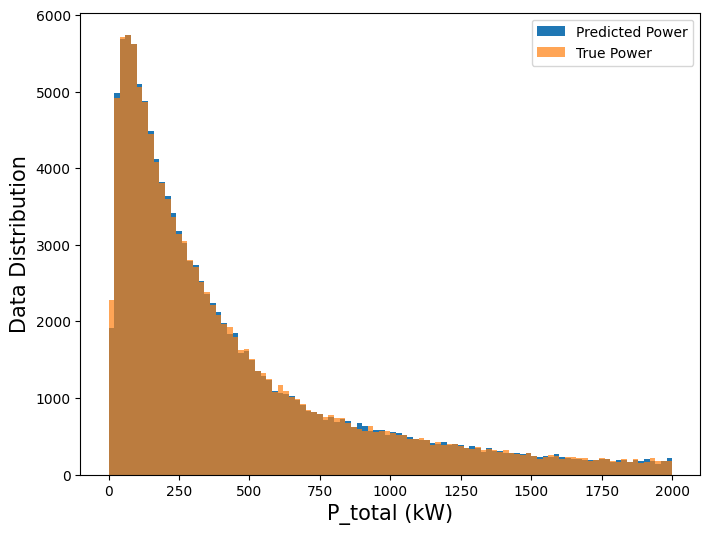

In [5]:
# Plot distributions of P_res in kW
Ptotal_data = Ptotal_model.predict(features_dataset)
plt.figure(figsize=(8,6))
plt.hist(Ptotal_data/1000, range=[0, 2000], bins=100,label='Predicted Power')
plt.xlabel('P_total (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
#plt.title('Predicted Power',fontsize=20)
#plt.show()

Ptotal_data = P_dataset
#plt.figure(figsize=(4,4))
plt.hist(Ptotal_data/1000, range=[0, 2000], bins=100,label='True Power',alpha=0.7)
#plt.xlabel('P_total (kW)',fontsize=15)
#plt.ylabel('Data Distribution',fontsize=15)
#plt.title('True Power',fontsize=20)
plt.legend()
plt.show()

In [6]:
# Split test_dataset into calibration and validation sets for conformal prediction
from sklearn.model_selection import train_test_split
X_calib, X_val, y_calib, y_val = train_test_split(features_dataset, P_dataset, test_size=0.5, random_state=42)
print(X_calib.shape)
print(y_calib.shape)
print(X_val.shape)
print(y_val.shape)

(60265, 11)
(60265, 1)
(60265, 11)
(60265, 1)
